Before you begin, execute this cell to import numpy and packages from the D-Wave Ocean suite, and all necessary functions for the gate-model framework you are going to use, whether that is the Forest SDK or Qiskit. In the case of Forest SDK, it also starts the qvm and quilc servers.

In [2]:
%run -i "assignment_helper.py"
%matplotlib inline

/Users/gianlucafugante/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Available frameworks:
Qiskit
D-Wave Ocean


# Probabilistic graphical models

Recall that probabilistic graphical models capture a compact representation of a joint probability distribution through conditionally independence: random variable $X$ is conditionally independent of $Y$ given $Z$ $(X\perp Y|Z)$, if $P(X=x, Y=y|Z=z) = P(X=x|Z=z)P(Y=y|Z=z)$ for all $x\in X,y\in Y,z\in Z$. A Markov network is a type of probabilistic graphical models that allows cycles in the graph and uses global normalization of probabilities (i.e. a partition function). The factorization of the joint probability distribution is given as a sum $P(X_1, \ldots, X_N) = \frac{1}{Z}\exp(-\sum_k E[C_k])$, where $C_k$ are are cliques of the graph, and $E[.]$ is an energy defined over the cliques.

**Exercise 1** (2 points). Define a Markov random field of four binary random variables in `dimod`. Random variables $X_1$ and $X_3$ are conditionally independent given $X_2$. The random variable $X_4$ is independent of all the other variables. The coupling strength on all edges in the graph is -1. Apart from the coupling between nodes, we also consider an external field of strength 1 applied to all nodes. Store the resulting `BinaryQuadraticModel` in an object called `model`.

In [17]:
###
### YOUR CODE HERE
###

number_of_nodes = 4
h = {n: 1 for n in range(number_of_nodes)}
J = {(0,1): -1, (1,2): -1}
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.BINARY)
[i for i in model.quadratic]

[(1, 0), (2, 1)]

In [20]:
# Error in the assertion cell:
# in line 6 should be [(1, 0), (2, 1)] and not [(0, 1), (1, 2)]

In [12]:
assert isinstance(model, dimod.binary_quadratic_model.BinaryQuadraticModel)
assert model.vartype == dimod.BINARY
assert len(model.variables) == 4
assert [i for i in model.linear] == [0, 1, 2, 3]
assert [i for i in model.linear.values()] == [1, 1, 1, 1]
assert [i for i in model.quadratic] == [(0, 1), (1, 2)]
assert [i for i in model.quadratic.values()] == [-1, -1]

AssertionError: 

**Exercise 2** (2 points). Convert the `dimod` model to a `networkx` graph. Store it in an object called `G`. You can use the `add_nodes_from` and `add_edges_from` methods of the graph object and the `linear` and `quadratic` methods of the model object to construct the graph.

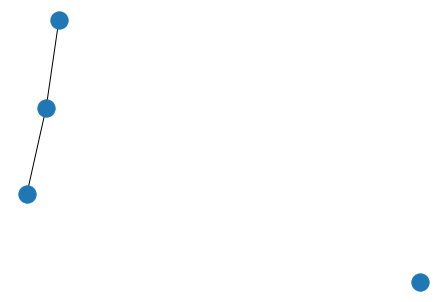

In [18]:
import networkx
G = networkx.Graph()
###
### YOUR CODE HERE
###

G.add_nodes_from(model.linear)
G.add_edges_from(model.quadratic)

networkx.draw(G)

In [19]:
assert list(G.nodes) == [0, 1, 2, 3]
assert list(G.edges) == [(0,1), (1, 2)]

Now you can easily plot the Markov network:

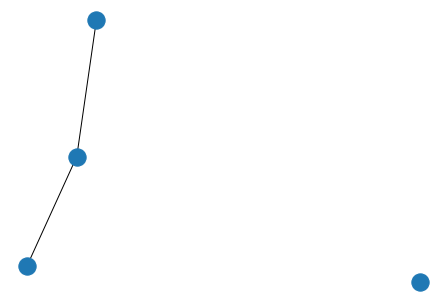

In [23]:
networkx.draw(G)

**Exercise 3** (1 point). If we want to use quantum annealing to draw samples, we have to address the connectivity structure on the chip. Embed the graph on a single Chimera cell using `minorminer`.

In [34]:
connectivity_structure = dwave_networkx.chimera_graph(1, 1)
###
### YOUR CODE HERE
###

#networkx.draw(connectivity_structure)
embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())


In [35]:
assert isinstance(embedded_graph, dict)
assert len(embedded_graph) == 3

This is a very simple Markov network that does not need multiple physical qubits to represent a logical qubit. Note that the independent random variable $X_4$ does not appear in the embedding.

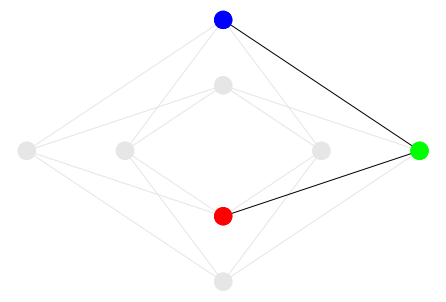

In [36]:
dwave_networkx.draw_chimera_embedding(connectivity_structure, embedded_graph)

**Exercise 4** (2 points). Estimate the partition function of this model at temperature $T=1$ from 100 samples. Store the value in a variable called `Z`.

In [37]:
###
### YOUR CODE HERE
###

T = 1
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, beta_range=[1/T, 1/T], num_reads=100)
degen = {}
for solution in response.aggregate().data():
    if solution.energy in degen.keys():
        degen[solution.energy] += 1
    else:
        degen[solution.energy] = 1
probabilities = np.array([degen[E] * np.exp(-E/T) for E in degen.keys()])
Z = probabilities.sum()

In [38]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


With these components in hand, you can start building a quantum-enhanced sampler for Markov networks.